# Term Project:  Clustering with BIRCH


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import Birch, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
%matplotlib inline

## 1.)  Model Description

BIRCH is a tree based clustering model, meaning it uses a tree data structure to determine cluster membership.

It works well on very large datasets because it combines the information of multiple data points into a single piece of information called a clustering feature.  After everything is condensed, we then perform other clustering algorithms on the condensed data to get results very quickly.

Two important measures here are threshold, which sets the maximum radius of a cluster, and the branching factor, which sets the maximum amount of cluster features a node on the tree can hold.

Firstly, the algorithm builds the tree, called a clustering feature tree.  This tree is balanced, meaning there is nowhere on the tree where the difference in height between the left subtree and right subtree is more than 1 level.

To do that, we define the Clustering Feature of the entire tree as an ordered 3-tuple with 3 components:

**N** - The number of entries to be clustered

**Linear Sum** - Every entry in the dataset can be treated as a vector where the individual entries are its weights.  LS is the linear sum, meaning we add all the vectors (entries) in the dataset together while multiplying each one to a scalar.  This is also called a linear combination (thanks linear algebra courses!).  For each vector in this case, the scalar we're multiplying each vector by would be 1 so no distortion takes place.  Each vector is just entirely added together across the entire dataset.

**Square Sum** - The same as the linear sum, but before adding each vector together, we square each of its features.

Each node on the tree is a Clustering Feature (CF).  If a node on the tree isn't a leaf node, it only contains a CF entry that is the combination of every CF entry of its child nodes (So CF entries get smaller as we go down the tree.  The root node represents the CF of every element, while CF entries further down represent individual clusters).  It's important to note that each leaf node represents one or more clustering features, so this algorithm essentially takes in spatial data about points and transforms it into an existing data structure, in this case being a tree.  

To build the clustering feature tree, we introduce data points one by one to build the tree.  Remember, each leaf represents at least one clustering feature in n dimensional space.  For example, the starting point of the tree may look like this if we were to overlay it with the points in space it represents:

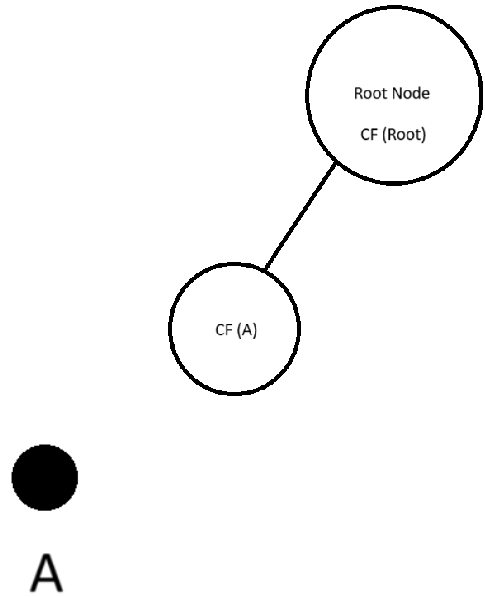

The algorithm then finds the point closest to the leaf on the tree containing Clustering Feature A using a distance formula and attempts to merge it into cluster A.  In doing this, the radius of the cluster may be changed if the point is further away from the centroid of the cluster than the other points within it.  As long as adding B to cluster A does not make the radius of cluster A larger than threshold T, the cluster stays the same, like this.  When a data point is merged, we update the CF of the leaf node that contains with clustering feature to now include this new data point (by adding 1 to N and recalculating Linear Sum and Square Sum)

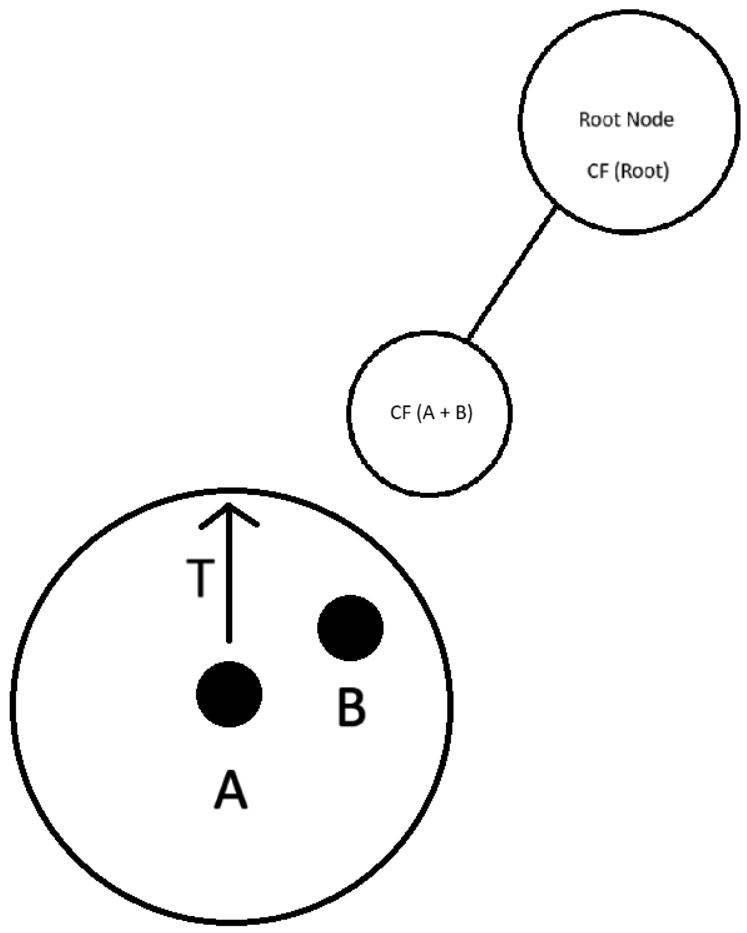

If a data point C is introduced that belongs outside cluster A, a new cluster C is created and it is assigned to it.  When we add a new Cluster to the tree, we calculate a new CF and add it onto the same leaf node as the current CF.  Note here that we add this new CF to the same leaf node as CF A, because we have already calculated that this leaf node contains the CFs that are closest to this point.  If this means that this leaf node contains more CF entries than the branching factor, we split this leaf node in half and divide each CF evenly between the two new leaf nodes, using a distance metric.  For this example, we'll use a branching factor of 1. 

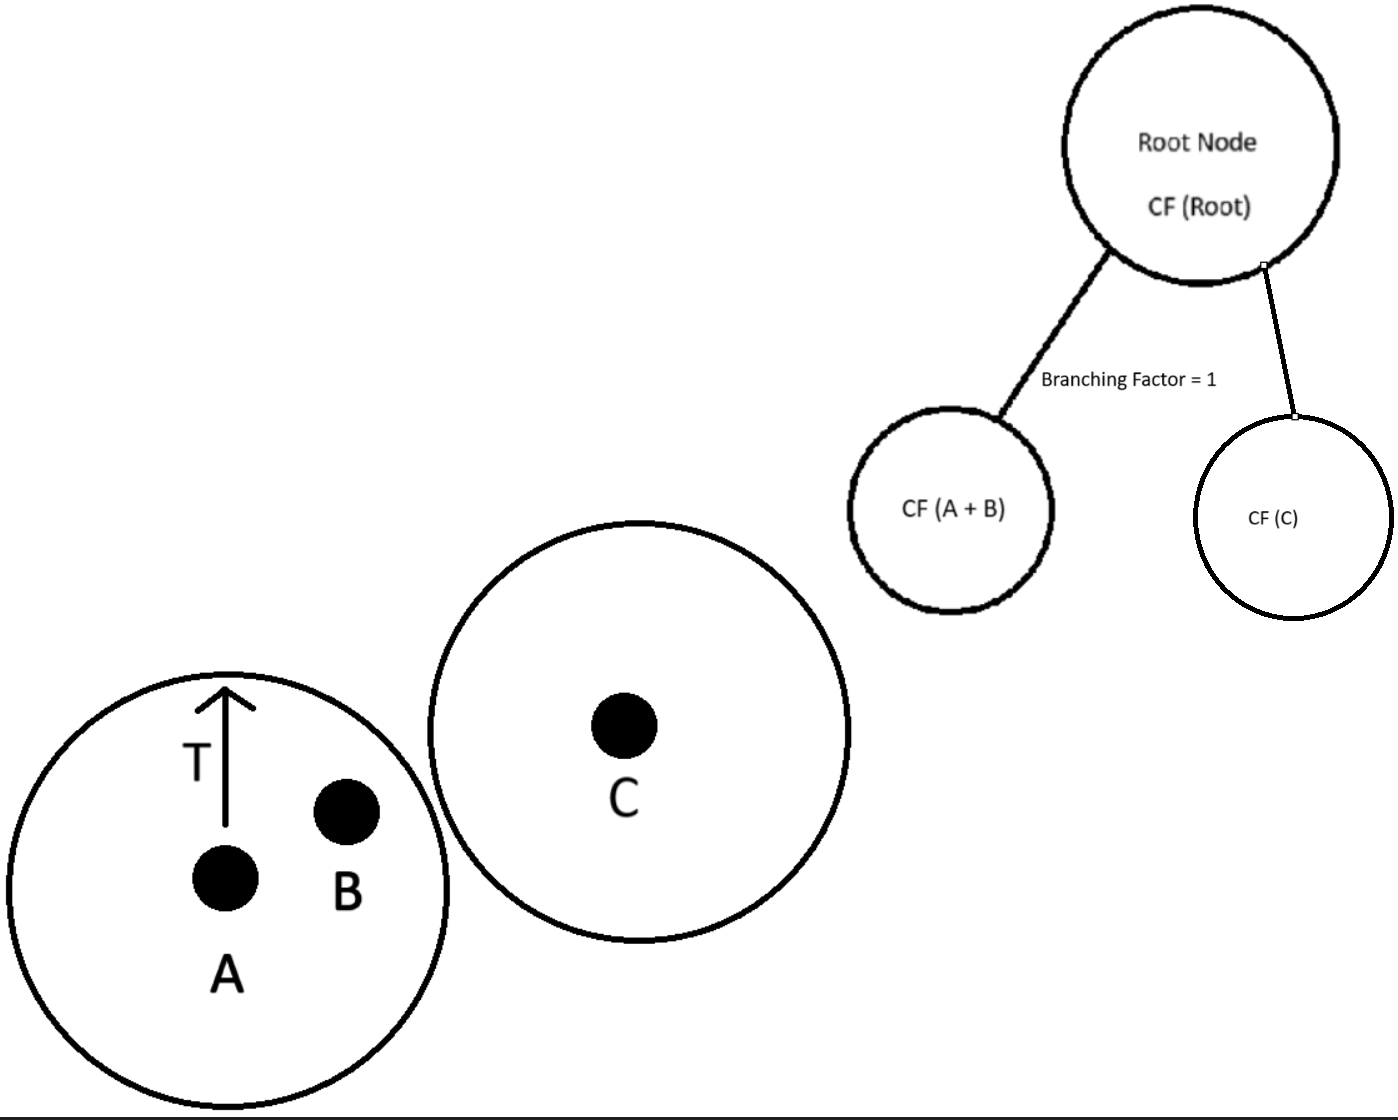

In either case, after we either update a CF or create a new CF entry, we have to update every non leaf node higher on the tree to also contain the information added to this new CF.  We recursively recalculate the CF of each parent node to the one we've updated.  If we add a new CF entry to a leaf, we add a new CF entry to the parent node of this leaf to show that this new CF entry exists.  Recursively, if adding this new CF entry onto the non leaf node exceeds the branching factor, we split this node and divide its CF entries (and the children each entry points to) evenly between the two newly created nodes, and so on.

If the root node is ever split, we increase the height of the tree by one by redefining a new root node that contains the CF for the entire tree, and having it point to both halves of the previously split node.

After building the tree, we then use an algorithm to group clusters with lots of datapoints into larger ones by getting rid of their associated leaf node and instead updating the node next highest on the tree.  This makes our tree much smaller.

Next, we use any other clustering algorithm not on the original data points, but instead on the clustering features to cluster them together, updating the tree with our results.

Finally, we Use the same tree building algorithm as the first part of BIRCH to scan over the tree again, strengthening it and making it smaller.

After all of this, we have our data divided into clusters.

## 2.)  Dataset Description

The dataset I'm using here is a well known dataset of the chemical attributes of one brand of wine, pulled from the University of California at Irvine's Machine Learning Repository. (https://archive.ics.uci.edu/dataset/186/wine+quality).  The dataset is contained in two csv files (one for red wine, the other white wine) that have 13 fields, of which 11 of those are features.  They are as follows:

**Fixed Acidity** - The amount of nonvolatile acids present in the wine.  Mostly affects the acidity in the wine's taste.

**Volatile Acidity** - The amount of volatile acids present in the wine, produced through distillation.  Greatly affects the wine's taste, and can ruin it if it is too present.

**Citric Acid** - The amount of citric acid present in the wine.  Often used to add citrus flavor to wines that are not acidic enough, so that they don't taste flat.

**Residual Sugar** - The amount of sugar left over in the wine after the fermentation process.

**Chlorides** - The amount of chlorides present in the wine.  Changes how salty the wine tastes depending on its level.

**Free Sulfur Dioxide** - Sulfur dioxide not bound to other molecules in the wine.  Has antioxidant properties, preventing the wine from spoiling.

**Total Sulfur Dioxide** - All sulfur dioxide present in the wine, including that which has bonded to other compounds.  Too much gives the wine a bitter taste.

**Density** - The physical density of the wine.  Density is often an indicator of alcohol content in the wine.  Higher density, higher alcohol content.

**pH** - The pH of the wine.  Lower pH means more acidic, higher pH means more basic.  Greatly affects flavor.

**Sulphates** - The content of sulphate present in the wine.  Affects taste.

**Alcohol** - The alcohol content of the wine.  

The dataset include two other fields, that being the **quality rating**, the target variable, which we will not be using here.  It also includes a categorical **color** field, to differentiate between red and white wine.  In this case, we will be combining red and white wines together and sampling evenly from both classes using stratified sampling, preserving the color field for later analysis.

## 3.)  Data Cleanup

The dataset I'm using came very ready-made, so very little cleanup is needed.  It does not contain any missing data or have any formatting issues, so the only thing that we'll need to do to have it ready for implementation is to remove the fields we aren't using as features (those being wine quality and wine color, which we'll save to we can use them for later analysis).  The only thing we'll need to do is tell the parsing engine that the delimter for this csv is a semicolon instead of a comma so it can read these fields properly.

In [4]:
df_white_wine = pd.read_csv('winequality-white.csv', sep = ';')
df_red_wine = pd.read_csv('winequality-red.csv', sep = ';')
df_red_wine['color'] = 'red'
df_white_wine['color'] = 'white'
#Combining both dataframes together
df_wine = pd.concat([df_white_wine, df_red_wine])

#This dataset is too large to visualize, so we sample evenly from each color of wine using stratified sampling.
df_wine = df_wine.groupby('color', group_keys = False).apply(lambda group: group.sample(1000, random_state = 400))

#Then we'll reset the indexing of the dataframe so we don't have repeat indices.
df_wine.reset_index(inplace = True)\

#Storing wine quality and wine color series for later use in analysis
df_wine_quality = df_wine['quality'].copy(deep = True)
df_wine.drop(columns = ['quality'], inplace = True)

df_wine_color = df_wine['color'].copy(deep = True)
df_wine.drop(columns = ['color'], inplace = True)

#Dropping the index column left over after resetting indices
df_wine.drop(columns = ['index'], inplace = True)

#As you can see here, everything is cleaned up and no values are empty.
print("Are there missing values?  ", df_wine.isnull().values.any())
df_wine

Are there missing values?   False


C:\Users\meaje\AppData\Local\Temp\ipykernel_18412\3565058529.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wine = df_wine.groupby('color', group_keys = False).apply(lambda group: group.sample(1000, random_state = 400))


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.1,0.715,0.00,2.35,0.071,21.0,47.0,0.99632,3.29,0.45,9.4
1,5.2,0.645,0.00,2.15,0.080,15.0,28.0,0.99444,3.78,0.61,12.5
2,6.9,0.550,0.15,2.20,0.076,19.0,40.0,0.99610,3.41,0.59,10.1
3,8.3,0.310,0.39,2.40,0.078,17.0,43.0,0.99444,3.31,0.77,12.5
4,8.3,0.430,0.30,3.40,0.079,7.0,34.0,0.99788,3.36,0.61,10.5
...,...,...,...,...,...,...,...,...,...,...,...
1995,7.1,0.200,0.31,6.85,0.053,32.0,211.0,0.99587,3.31,0.59,10.4
1996,6.5,0.180,0.41,14.20,0.039,47.0,129.0,0.99678,3.28,0.72,10.3
1997,5.9,0.445,0.26,1.40,0.027,23.0,109.0,0.99148,3.30,0.36,10.5
1998,7.4,0.260,0.31,2.40,0.043,58.0,178.0,0.99410,3.42,0.68,10.6


## 4.)  Research Question

My research question is very simple.  My  model is a clustering model, so my goal is to find clusters in this data.  After finding these clusters, my goal is to determine what they represent.  For example, do wines labeled red tend to be clustered together?  Is the same true for white wines?  Are there certain subtypes of wine clustered together?  And finally, are these clusters indicative of quality in any resonable sense?  Do people tend to like one 'kind' of wine over another?

## 5.)  Result Expectations

My current expectations of the results is that there is going to be 2 to 4 clusters in this dataset.  I expect to see white and red wines entirely separate from each other, as well as some differing subtypes of wine like to perhaps be present, although that may be unlikely seeing as this dataset is the data of a white and red version of a specific brand of wine.

I expect my model to be mostly correct, however working in 11 dimensions is definitely going to make it such that my model won't be extremely accurate.  That's to be expected with this sort of higher dimensional clustering analysis, especially when everything is so close together with values that are very similar to each other even when types of wine differ.

# Implementation

##  Data Before Clustering Algorithm:

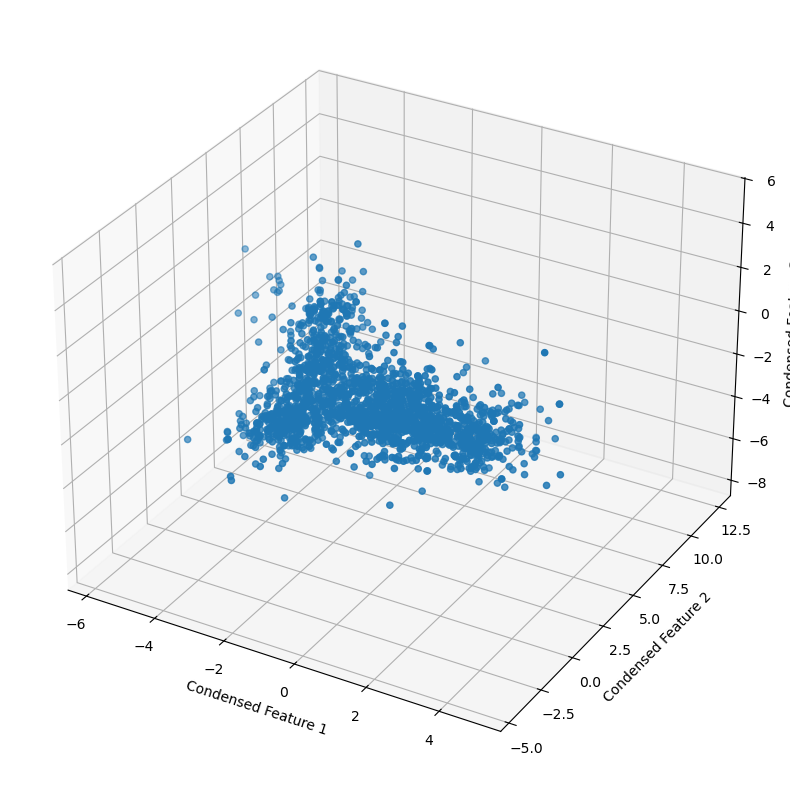

In [7]:
#A problem with vizualizing this data is that all of these metrics use different scales.  To fix this, we use StandardScaler in sklearn
#to scale the measures equally.
scaled_data = StandardScaler().fit_transform(df_wine)

#This performs principal component analysis, a linear reduction method that reduces our dimensions from 11 to 3 so we can visualize the data with a graph.
pca = PCA(n_components = 3)
decomposed_data = pca.fit_transform(scaled_data)
df_wine_decomposed = pd.DataFrame(data = decomposed_data, columns = ['Feature1', 'Feature2', 'Feature3'])

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_wine_decomposed['Feature1'], df_wine_decomposed['Feature2'], df_wine_decomposed['Feature3'])
ax.set_xlabel('Condensed Feature 1')
ax.set_ylabel('Condensed Feature 2')
ax.set_zlabel('Condensed Feature 3')
plt.show()
#From what I see here, it looks like our data is going to have two large clusters.

## Data After Clustering Algorithm

Silhouette score for k =  2  is:   0.5852864124976586
Silhouette score for k =  3  is:   0.4683674095438388
Silhouette score for k =  4  is:   0.44017272696508053
Silhouette score for k =  5  is:   0.42922668043508566
Silhouette score for k =  6  is:   0.3987955018725602
Silhouette score for k =  7  is:   0.3931038500672081
Silhouette score for k =  8  is:   0.3521001818803143
Silhouette score for k =  9  is:   0.3605352941191812
Silhouette score for k =  10  is:   0.34800266200726004
Silhouette score for k =  11  is:   0.35656030164686864
Silhouette score for k =  12  is:   0.30300816866210767
Silhouette score for k =  13  is:   0.29506077144566556
Silhouette score for k =  14  is:   0.29365600487056503
Silhouette score for k =  15  is:   0.2968758482222851
Silhouette score for k =  16  is:   0.30408391310517
Silhouette score for k =  17  is:   0.30023522730776303
Silhouette score for k =  18  is:   0.3035314173308696
Silhouette score for k =  19  is:   0.30398128069759806


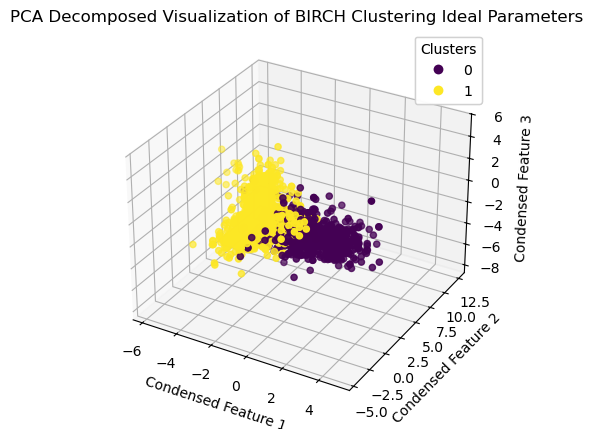

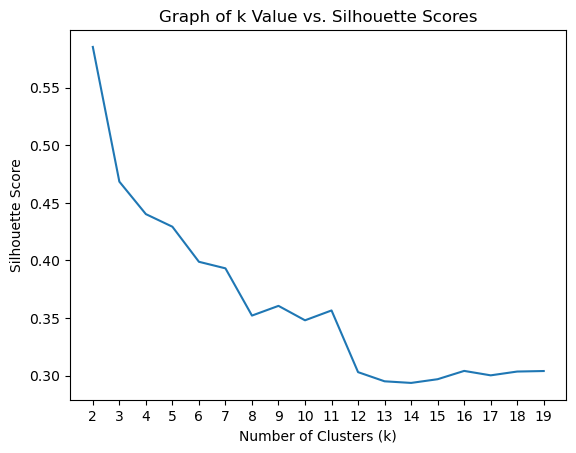

In [9]:
#We test for different k values here, just for emphasis on which is best
k_range = range(2, 20)
silhouette_scores = []
for k in k_range:
    birch = Birch(n_clusters = k)
    birch.fit(df_wine)
    score = silhouette_score(df_wine, birch.labels_)
    silhouette_scores.append(score)
    print("Silhouette score for k = ", k, " is:  ", silhouette_score(df_wine, birch.labels_))

#k = 2 has the best silhouette score, so we'll vizualize it here with a graph.
ideal_k = 2
birch = Birch(n_clusters = ideal_k)
birch.fit(df_wine)
fig2 = plt.figure(figsize = (5, 5))
ax = fig2.add_subplot(111, projection='3d')
graph = ax.scatter(df_wine_decomposed['Feature1'], df_wine_decomposed['Feature2'], df_wine_decomposed['Feature3'], c = birch.labels_)
handles, labels = graph.legend_elements()
plot_legend = ax.legend(handles = handles, labels = [0, 1], title = 'Clusters')
ax.add_artist(plot_legend)
ax.set_xlabel('Condensed Feature 1')
ax.set_ylabel('Condensed Feature 2')
ax.set_zlabel('Condensed Feature 3')
ax.set_title('PCA Decomposed Visualization of BIRCH Clustering Ideal Parameters')
plt.show()

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 20))
plt.title('Graph of k Value vs. Silhouette Scores')
plt.show()

## 6.)  Result Evaluation

In order to assess the correctness of my model, I'll be using the silhouette score, a measure of how similar each data point is to other members of its cluster, and how different it is from members of other clusters.

After testing BIRCH implementation on multiple different k values, we find that the one that has the highest silhouette score (and therefore is the best at clustering this data) is k = 2, suggesting that our data has at most two clusters.  It is important to note that the silhouette score here is ~0.6, which while not extremely strong does indicate that this is moderately correct.  It is important to note that this somewhat low silhouette score is within reason and entirely expected because of the curse of dimensionality (an axiom in data analysis and math that says that data is much harder to work with in higher dimensions).  Essentially, when working with 11 dimensions, it's  very hard to cluster data together in a very accurate way, because of the way distance calculations change, as well as more and more features influencing how we calculate cluster membership.  With this data specifically, because the individual data points are so close together no matter what they are, this makes clustering even more difficult.  

Even with that being given, this is still very good for analysis, as it is extremely close to other, simpler datasets.  For example, here is a very simple 2D dataset we used for assignment 10 in class, and its silhouette score after using the BIRCH algorithm is almost identical to our higher dimensional BIRCH application

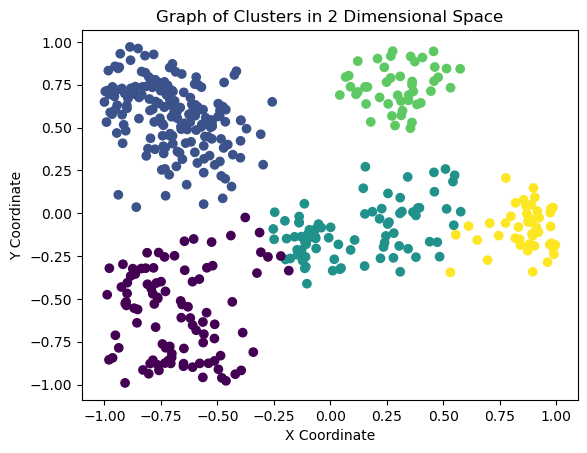

Silhouette Score is:   0.6040780687238445


In [11]:
df_low_dimension = pd.read_csv('data_low_dimension.csv')
birch_low_dimension = Birch(n_clusters = None)
birch_low_dimension.fit(df_low_dimension)
plt.scatter(df_low_dimension['x'], df_low_dimension['y'], c = birch_low_dimension.labels_)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Graph of Clusters in 2 Dimensional Space')
plt.show()
print("Silhouette Score is:  ", silhouette_score(df_low_dimension, birch_low_dimension.labels_))

## Here Are Those Same Datasets Clustered Using KMeans Clustering As A Point Of Comparison

As you can see, the results are very similar, marginally better.

C:\Users\meaje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\meaje\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


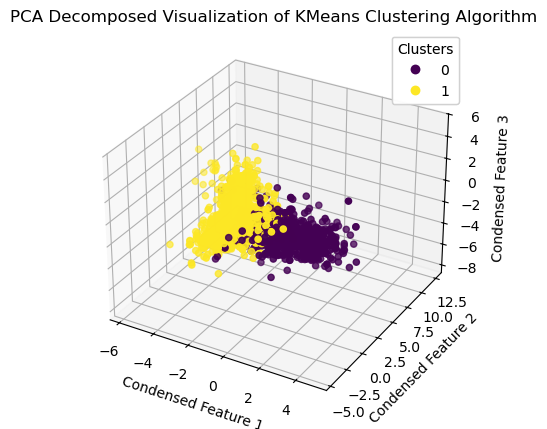

Silhouette Score is:   0.5932354183750178


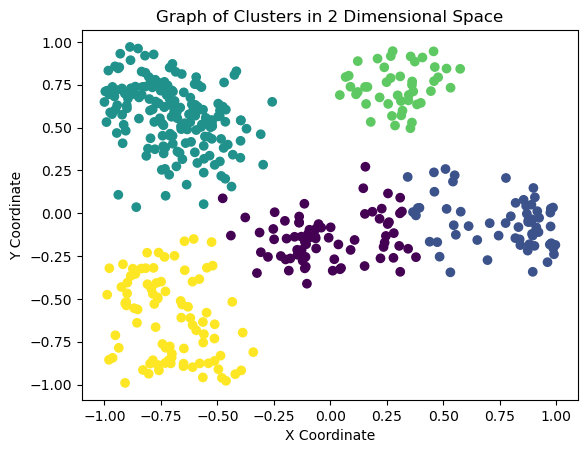

Silhouette Score is:   0.6114814690996501


In [13]:
KMeansWine = KMeans(n_clusters = 2)
KMeansWine.fit(df_wine)
WineScore = silhouette_score(df_wine, KMeansWine.labels_)

KMeansLowDim = KMeans(n_clusters = 5)
KMeansLowDim.fit(df_low_dimension)
LowDimScore = silhouette_score(df_low_dimension, KMeansLowDim.labels_)

fig2 = plt.figure(figsize = (5, 5))
ax = fig2.add_subplot(111, projection='3d')
graph = ax.scatter(df_wine_decomposed['Feature1'], df_wine_decomposed['Feature2'], df_wine_decomposed['Feature3'], c = KMeansWine.labels_)
handles, labels = graph.legend_elements()
plot_legend = ax.legend(handles = handles, labels = [0, 1], title = 'Clusters')
ax.add_artist(plot_legend)
ax.set_xlabel('Condensed Feature 1')
ax.set_ylabel('Condensed Feature 2')
ax.set_zlabel('Condensed Feature 3')
ax.set_title('PCA Decomposed Visualization of KMeans Clustering Algorithm')
plt.show()
print("Silhouette Score is:  ", WineScore)

plt.scatter(df_low_dimension['x'], df_low_dimension['y'], c = KMeansLowDim.labels_)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Graph of Clusters in 2 Dimensional Space')
plt.show()
print("Silhouette Score is:  ", LowDimScore)

## How Can We Improve This Model?

The main way this model could be improved would be through tweaking settings in the BIRCH algorithm itself to allow it to better represent cluster membership.  These fields are all able to be changed in the BIRCH constructor.  They are:

**Threshold** - Similar to setting the radius in DBSCAN.  Essentially, any data point that wants to become part of a subcluster in the BIRCH algorithm must make it so that the new radius of the subcluster is less than this threshold.  If we set it lower, that means that we want more subclusters, while if we set it higher we allow less subclusters.  We can tweak this to find the ideal value.

**Branching Factor** - This has to do with the tree structure BIRCH uses.  Increasing the branching factor allows more subclusters on the tree before they are split between different branches.  Essentially, a higher branching factor means less branches on the tree, while a lower branching factor means more branches on the tree.

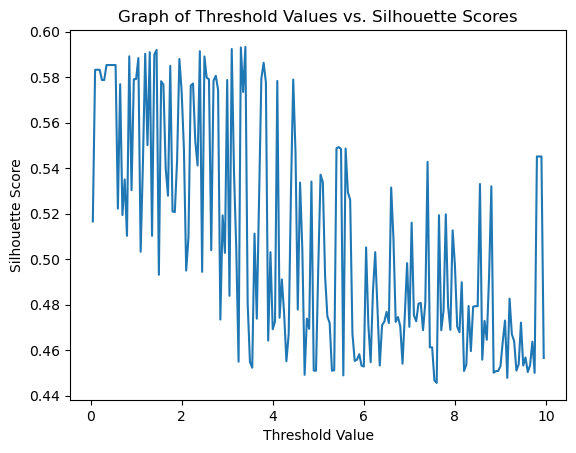

In [15]:
thresholds = np.arange(.05, 10, .05)
threshold_scores = []
for t in thresholds:
    birch = Birch(n_clusters = 2, threshold = t)
    birch.fit(df_wine)
    score = silhouette_score(df_wine, birch.labels_)
    threshold_scores.append(score)
ideal_t = 3.4
plt.plot(thresholds, threshold_scores)
plt.xlabel('Threshold Value')
plt.ylabel('Silhouette Score')
plt.title('Graph of Threshold Values vs. Silhouette Scores')
plt.show()

This honestly doesn't tell us too much about which threshold to use other than the fact that the threshold's efficacy is largely just dependent on how it interacts with the data itself.  You can see that in how it will randomly go up and down as certain values make it so that the data is better integrated.  There is a visible trend that silhouette score is more likely to be less accurate as the threshold value goes up.  You can see this on the plot with how the valleys of the graph are continually getting lower as threshold score increases.

That being said, the best threshold score is found at t = 3.4, with silhouette score 0.5932412.  So that will be our ideal.

Next,  we'll test different branching factor values.

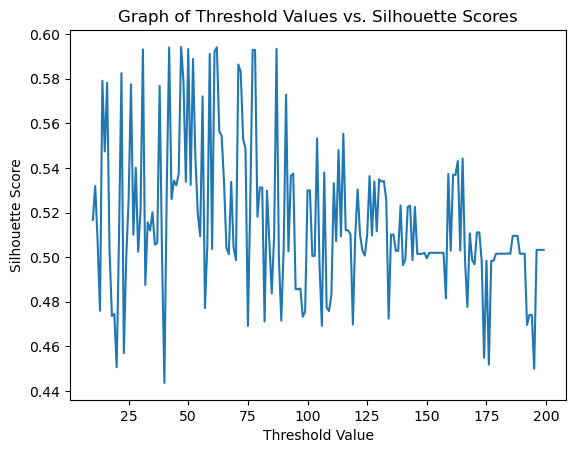

In [17]:
branching_factors = range(10, 200)
branching_scores = []
for b in branching_factors:
    birch = Birch(n_clusters = ideal_k, threshold = ideal_t, branching_factor = b)
    birch.fit(df_wine)
    score = silhouette_score(df_wine, birch.labels_)
    branching_scores.append(score)
ideal_b = 47
plt.plot(branching_factors, branching_scores)
plt.xlabel('Threshold Value')
plt.ylabel('Silhouette Score')
plt.title('Graph of Threshold Values vs. Silhouette Scores')
plt.show()

As you can see here, similarly with threshold value, the ideal branching factor really just  depends on how it reacts to the given data.  As it gets larger you can see that the silhouette score is trending lower.  

With that being said, the best silhouette score is at b = 47, with a score of 0.5942085

Now, to put it all together, visualized:

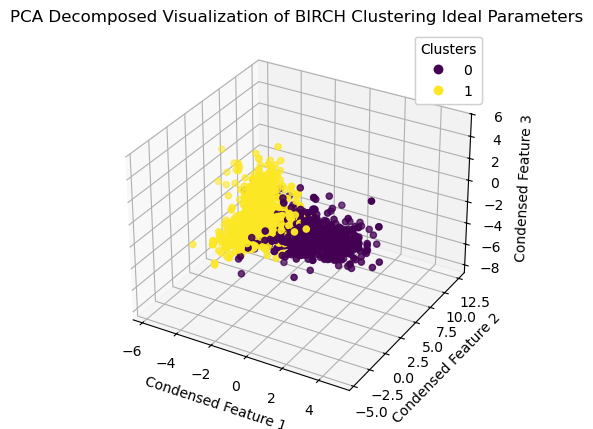

Silhouette score with idealized conditions:   0.5942085768665588


In [19]:
birch = Birch(n_clusters = ideal_k, threshold = ideal_t, branching_factor = ideal_b)
birch.fit(df_wine)
score = silhouette_score(df_wine, birch.labels_)

fig3 = plt.figure(figsize = (5, 5))
ax = fig3.add_subplot(111, projection='3d')
graph = ax.scatter(df_wine_decomposed['Feature1'], df_wine_decomposed['Feature2'], df_wine_decomposed['Feature3'], c = birch.labels_)
handles, labels = graph.legend_elements()
plot_legend = ax.legend(handles = handles, labels = [0, 1], title = 'Clusters')
ax.add_artist(plot_legend)
ax.set_xlabel('Condensed Feature 1')
ax.set_ylabel('Condensed Feature 2')
ax.set_zlabel('Condensed Feature 3')
ax.set_title('PCA Decomposed Visualization of BIRCH Clustering Ideal Parameters')
plt.show()
print("Silhouette score with idealized conditions:  ", score)

As you can see this is quite similar to earlier, but it is a bit more accurate, as there is a little less overlap between the two clusters.  

Now, to analyze these clusters and see if they mean anything significant to our data.

The first thing I'm looking to test for here is to see if these clusters are indicative of the color of wine these points represent.

In [21]:
#First we combine the dataframes for our wine features, our labels, and our wine colors.
df_labels = pd.DataFrame(birch.labels_, columns = ['cluster label'])
df_wine_labeled = pd.merge(df_wine, df_labels, left_index = True, right_index = True)
df_wine_labeled = pd.merge(df_wine_labeled, df_wine_color, left_index = True, right_index = True)

#Next, to see if cluster value indicates color of wine, we'll group by cluster label and see what color of wine dominates each cluster.

df_wine_labeled.groupby('cluster label')['color'].value_counts()

#As you can see here, while not perfect, cluster 0 is very heavily skewed towards white wine while cluster 1 is heavily skewed towards red wine.
#Thus cluster 0 would represent white wine and cluster 1 would represent red wine.

cluster label  color
0              white    891
               red      113
1              red      887
               white    109
Name: count, dtype: int64

The second thing I'll test for, and this is mostly for fun, is to take the average quality of each cluster and see which one people generally like more.

In [23]:
df_wine_labeled = pd.merge(df_wine_labeled, df_wine_quality, left_index = True, right_index = True)
df_wine_labeled.groupby('cluster label')['quality'].mean()

cluster label
0    5.782869
1    5.689759
Name: quality, dtype: float64

Overall, the quality of these is very similar, however people generally seem to like cluster 0 wine slightly more, generally white wine.

It's important not to take this point of data too seriously, seeing as we're sampling from a larger dataset here and this difference could be due to variation in sampling.  However, it is still interesting considering white wine generally has less harsh of a flavor than red wine, meaning more people may enjoy it compared to red wine, which is much richer with more pronounced flavors.

## References

I used references for each of the libraries I implemented, and I'll list them here with links.

### pandas:

Pandas Dataframe Reference Page (https://pandas.pydata.org/docs/reference/frame.html)

Pandas Cheat Sheet (https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

### sklearn:

sklearn Clustering Guide (https://scikit-learn.org/stable/modules/clustering.html#birch)

BIRCH Reference Page (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html)

StandardScaler Reference Page (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

PCA Reference Page (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

Silhouette Score Reference Page (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)


### matplotlib:

Pyplot Reference Page (https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

Axes3D Reference Page (https://matplotlib.org/3.5.1/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html)

Pyplot Legend Reference Page (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)


### numpy:

Numpy API Reference, only for certain functions like arange (https://numpy.org/doc/2.2/reference/index.html#reference)

### dataset and model information:

Wine Dataset (https://archive.ics.uci.edu/dataset/186/wine+quality)

Medium Post by Noel Benzer Explaining BIRCH (https://medium.com/@noel.cs21/balanced-iterative-reducing-and-clustering-using-heirachies-birch-5680adffaa58)

BIRCH Algorithm Wikipedia page, and the paper it draws from (https://en.wikipedia.org/wiki/BIRCH) (https://dl.acm.org/doi/10.1145/235968.233324)
